This notebook is for Daniels, Zhong, and Balsam (In Prep): Tracking of Sinusoidal Time is Not Scalar Invariant

The goal of the present work was to replicate some of the work of Staddon and colleagues using a more tradtional timing task (FI schedule) and determine whether timing is scalar invariant. This analysis is a wip and subject to change. 

In [175]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
import re
from datetime import date
pd.set_option('display.max_rows', 10000)
import warnings
warnings.filterwarnings('ignore')
import scipy.optimize as optimization
from scipy import signal
import statsmodels.formula.api as smf
import scipy.io
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 0.5

In [176]:
tracked_data_e1 = pd.read_csv("exp1_updated_data.csv")
tracked_data_e1 = tracked_data_e1[["SubjectID","Session","SessionCode","Trial","ProgFI","ObtFI","Lat","Breakpoint"]]

In [177]:
tracked_data_e2 = pd.read_csv("exp2_updated_data.csv")
tracked_data_e2 = tracked_data_e2[["SubjectID","Session","SessionCode","Trial","ProgFI","ObtFI","Lat","Breakpoint"]]

In [178]:
all_racked_data = pd.concat([tracked_data_e1,tracked_data_e2],axis=0)
all_racked_data

,SubjectID,Session,SessionCode,Trial,ProgFI,ObtFI,Lat,Breakpoint
0,21,7,1,1,5.00,7.09,4.70,4.70
1,21,7,1,2,5.00,6.04,1.93,3.65
2,21,7,1,3,5.00,5.40,0.92,2.37
3,21,7,1,4,5.00,7.94,0.92,3.09
4,21,7,1,5,5.00,5.90,1.04,1.59
...,...,...,...,...,...,...,...,...
81064,181,193,4,57,22.94,23.91,1.22,16.43
81065,181,193,4,58,31.46,31.54,1.87,2.18
81066,181,193,4,59,44.73,44.95,3.82,5.92
81067,181,193,4,60,61.46,61.51,4.20,13.83


In [179]:
rr_data_e1 = pd.read_csv("exp1_updated_data_rr.csv")
rr_data_e1 = rr_data_e1[["SubjectID","Session","Trial","Bin","Rsp"]]
rr_data_e2 = pd.read_csv("exp2_updated_data_rr.csv")
rr_data_e2 = rr_data_e2[["SubjectID","Session","Trial","Bin","Rsp"]]

Response rate as a function of time in FI analysis
Select baseline data equivalent to similar amounts of training (36 sessions in total)

In [180]:
rr_base20_base40 = rr_data_e1[(rr_data_e1['Session']<=63) & (rr_data_e1['Session']>=51)]
#find all Base20 mice
rr_base20_base40.loc[(rr_base20_base40['SubjectID']==21) | (rr_base20_base40['SubjectID']==23) | (rr_base20_base40['SubjectID']==26) | (rr_base20_base40['SubjectID']==28) | (rr_base20_base40['SubjectID']==30) | (rr_base20_base40['SubjectID']==32) | (rr_base20_base40['SubjectID']==33) | (rr_base20_base40['SubjectID']==35),'Group']='Base20'
rr_base20_base40.loc[(rr_base20_base40['SubjectID']==22) | (rr_base20_base40['SubjectID']==24) | (rr_base20_base40['SubjectID']==25) | (rr_base20_base40['SubjectID']==27) | (rr_base20_base40['SubjectID']==29) | (rr_base20_base40['SubjectID']==31) | (rr_base20_base40['SubjectID']==34) | (rr_base20_base40['SubjectID']==36),'Group']='Base40'
#Replace session 50 with 63 because of operant chamber malfunction
rr_base20_base40[(rr_base20_base40['SubjectID']>=29) & (rr_base20_base40['Session']==50)] = rr_base20_base40[(rr_base20_base40['SubjectID']>=29) & (rr_base20_base40['Session']==63)]
#Drop session 63 because not needed for baseline
rr_base20_base40 = rr_base20_base40[rr_base20_base40['Session']<=62]

In [181]:
#Organize baseline of e2 data (Base 60)
rr_base60 = rr_data_e2[(rr_data_e2['Session']<=62) & (rr_data_e2['Session']>= 51)]
#Add group identifier
rr_base60['Group' ] = 'Base60'

In [182]:
#concatenate all data
all_rr_base = pd.concat([rr_base20_base40,rr_base60],axis=0)

In [183]:
all_rr_base

,SubjectID,Session,Trial,Bin,Rsp,Group
343552,21,51,0,0,0.000000,Base20
343553,21,51,0,1,0.000000,Base20
343554,21,51,0,2,0.800000,Base20
343555,21,51,0,3,1.600000,Base20
343556,21,51,0,4,2.800000,Base20
...,...,...,...,...,...,...
202027,184,62,60,3,0.000000,Base60
202028,184,62,60,4,1.066667,Base60
202029,184,62,60,5,3.466667,Base60
202030,184,62,60,6,4.533333,Base60


In [184]:
#Add FI information to RR
for subj in all_rr_base.SubjectID.unique():
    for sess in all_rr_base[all_rr_base['SubjectID']==subj].Session.unique():
        all_rr_base.loc[(all_rr_base['SubjectID']==subj) & (all_rr_base['Session']==sess),'ProgFI'] = np.repeat(all_racked_data[(all_racked_data['SubjectID']==subj) & (all_racked_data['Session']==sess)].ProgFI.to_numpy(),8)
        
all_rr_base['LogRate'] = np.log(all_rr_base.Rsp+0.001)

In [185]:
#Add ascending and dscending information to lat and bp data
for subj in all_racked_data.SubjectID.unique():
    for sess in all_racked_data[all_racked_data['SubjectID']==subj].Session.unique():
        if all_racked_data[(all_racked_data['SubjectID']==subj) & (all_racked_data['Session']==sess)].ProgFI.to_numpy()[0] - all_racked_data[(all_racked_data['SubjectID']==subj) & (all_racked_data['Session']==sess)].ProgFI.to_numpy()[1] == 0:
            all_racked_data.loc[(all_racked_data['SubjectID']==subj) & (all_racked_data['Session']==sess),'Direction'] = 'Static'
        elif all_racked_data[(all_racked_data['SubjectID']==subj) & (all_racked_data['Session']==sess)].ProgFI.to_numpy()[0] - all_racked_data[(all_racked_data['SubjectID']==subj) & (all_racked_data['Session']==sess)].ProgFI.to_numpy()[1] < 0:
            all_racked_data.loc[(all_racked_data['SubjectID']==subj) & (all_racked_data['Session']==sess),'Direction'] = 'Ascending'
        else:
            all_racked_data.loc[(all_racked_data['SubjectID']==subj) & (all_racked_data['Session']==sess),'Direction'] = 'Descending'

In [186]:
print(all_racked_data)

       SubjectID  Session  SessionCode  Trial  ProgFI  ObtFI   Lat  \
0             21        7            1      1    5.00   7.09  4.70   
1             21        7            1      2    5.00   6.04  1.93   
2             21        7            1      3    5.00   5.40  0.92   
3             21        7            1      4    5.00   7.94  0.92   
4             21        7            1      5    5.00   5.90  1.04   
...          ...      ...          ...    ...     ...    ...   ...   
81064        181      193            4     57   22.94  23.91  1.22   
81065        181      193            4     58   31.46  31.54  1.87   
81066        181      193            4     59   44.73  44.95  3.82   
81067        181      193            4     60   61.46  61.51  4.20   
81068        181      193            4     61   80.00  80.04  6.47   

       Breakpoint  Direction  
0            4.70     Static  
1            3.65     Static  
2            2.37     Static  
3            3.09     Static  
4   

In [187]:
#Calculate response rate/bin for each FI
fi_rr = all_rr_base.LogRate.groupby([all_rr_base['SubjectID'],all_rr_base['Group'],all_rr_base['ProgFI'],all_rr_base['Bin']]).mean()
fi_rr = fi_rr.reset_index()
fi_rr['ExpRate'] = np.exp(fi_rr.LogRate) - 0.001
fi_rr['UnBin'] = (fi_rr.Bin+1)*(fi_rr.ProgFI*(1/8))
fi_rr['PropBin'] = fi_rr.Bin/7
for subj in fi_rr.SubjectID.unique():
    for FI in fi_rr.ProgFI[fi_rr['SubjectID']==subj].unique():
        fi_rr.loc[(fi_rr['SubjectID']==subj) & (fi_rr['ProgFI']==FI), 'PropRate'] = fi_rr.ExpRate[(fi_rr['SubjectID']==subj) & (fi_rr['ProgFI']==FI)]/np.max(fi_rr.ExpRate[(fi_rr['SubjectID']==subj) & (fi_rr['ProgFI']==FI)])


In [188]:
racked_base20_base40 = tracked_data_e1[(tracked_data_e1['Session']<=63) & (tracked_data_e1['Session']>=51)]
#find all Base20 mice
racked_base20_base40.loc[(racked_base20_base40['SubjectID']==21) | (racked_base20_base40['SubjectID']==23) | (racked_base20_base40['SubjectID']==26) | (racked_base20_base40['SubjectID']==28) | (racked_base20_base40['SubjectID']==30) | (racked_base20_base40['SubjectID']==32) | (racked_base20_base40['SubjectID']==33) | (racked_base20_base40['SubjectID']==35),'Group']='Base20'
racked_base20_base40.loc[(racked_base20_base40['SubjectID']==22) | (racked_base20_base40['SubjectID']==24) | (racked_base20_base40['SubjectID']==25) | (racked_base20_base40['SubjectID']==27) | (racked_base20_base40['SubjectID']==29) | (racked_base20_base40['SubjectID']==31) | (racked_base20_base40['SubjectID']==34) | (racked_base20_base40['SubjectID']==36),'Group']='Base40'
#Replace session 50 with 63 because of operant chamber malfunction
racked_base20_base40[(racked_base20_base40['SubjectID']>=29) & (racked_base20_base40['Session']==50)] = racked_base20_base40[(racked_base20_base40['SubjectID']>=29) & (racked_base20_base40['Session']==63)]
#Drop session 63 because not needed for baseline
racked_base20_base40 = racked_base20_base40[racked_base20_base40['Session']<=62]

In [189]:
#Organize baseline of e2 data (Base 60)
racked_base60 = tracked_data_e2[(tracked_data_e2['Session']<=62) & (tracked_data_e2['Session']>= 51)]
#Add group identifier
racked_base60['Group' ] = 'Base60'

In [190]:
#recombine data again
all_racked_base = pd.concat([racked_base20_base40,racked_base60],axis=0)
all_racked_base['LogLat'] = np.log(all_racked_base.Lat)
all_racked_base['LogBP'] = np.log(all_racked_base.Lat)

In [191]:
for subj in all_racked_base.SubjectID.unique():
    for sess in all_racked_base[all_racked_base['SubjectID']==subj].Session.unique():
        if all_racked_base[(all_racked_base['SubjectID']==subj) & (all_racked_base['Session']==sess)].ProgFI.to_numpy()[0] - all_racked_base[(all_racked_base['SubjectID']==subj) & (all_racked_base['Session']==sess)].ProgFI.to_numpy()[1] == 0:
            all_racked_base.loc[(all_racked_base['SubjectID']==subj) & (all_racked_base['Session']==sess),'Direction'] = 'Static'
        elif all_racked_base[(all_racked_base['SubjectID']==subj) & (all_racked_base['Session']==sess)].ProgFI.to_numpy()[0] - all_racked_base[(all_racked_base['SubjectID']==subj) & (all_racked_base['Session']==sess)].ProgFI.to_numpy()[1] < 0:
            all_racked_base.loc[(all_racked_base['SubjectID']==subj) & (all_racked_base['Session']==sess),'Direction'] = 'Ascending'
        else:
            all_racked_base.loc[(all_racked_base['SubjectID']==subj) & (all_racked_base['Session']==sess),'Direction'] = 'Descending'

In [192]:
experimental_data = all_racked_base
for subj in experimental_data.SubjectID.unique():
    for sess in experimental_data[experimental_data['SubjectID']==subj].Session.unique():
        Progtemp = experimental_data[(experimental_data['SubjectID']==subj) & (experimental_data['Session']==sess)].ProgFI.to_numpy()
        BPtemp = experimental_data[(experimental_data['SubjectID']==subj) & (experimental_data['Session']==sess)].Breakpoint.to_numpy()
        Lattemp = experimental_data[(experimental_data['SubjectID']==subj) & (experimental_data['Session']==sess)].Lat.to_numpy()
        if Progtemp[0] - Progtemp[1] > 0:
            experimental_data.loc[(experimental_data['SubjectID']==subj) & (experimental_data['Session']==sess),'ProgFI']= np.flip(Progtemp)
            experimental_data.loc[(experimental_data['SubjectID']==subj) & (experimental_data['Session']==sess),'Breakpoint'] = np.flip(BPtemp)
            experimental_data.loc[(experimental_data['SubjectID']==subj) & (experimental_data['Session']==sess),'Lat'] = np.flip(Lattemp)
print(experimental_data)

       SubjectID  Session  SessionCode  Trial  ProgFI  ObtFI    Lat  \
42944         21       51            4      1   20.00  20.09   3.06   
42945         21       51            4      2   24.64  24.83   0.51   
42946         21       51            4      3   28.82  29.07   5.40   
42947         21       51            4      4   32.14  32.30   4.43   
42948         21       51            4      5   34.27  34.74   4.40   
...          ...      ...          ...    ...     ...    ...    ...   
25249        184       62            4     57   17.20  17.59   3.48   
25250        184       62            4     58   23.59  24.08   3.18   
25251        184       62            4     59   33.55  33.77   4.86   
25252        184       62            4     60   46.09  46.13  15.00   
25253        184       62            4     61   60.00  60.02  31.50   

       Breakpoint   Group    LogLat     LogBP  Direction  
42944        8.74  Base20  1.118415  1.118415  Ascending  
42945        5.11  Base20 -0.

In [193]:
experimental_data['NormBP'] = experimental_data.Breakpoint
experimental_data['NormFI'] = experimental_data.ProgFI
baseFI_means = experimental_data.Breakpoint.groupby([experimental_data['Group'],experimental_data['SubjectID'],experimental_data['Trial']]).mean().reset_index()

for subj in experimental_data.SubjectID.unique():
    #norm BPs first
    temp = experimental_data.Breakpoint[experimental_data['SubjectID']==subj]
    temp2 = baseFI_means.Breakpoint[baseFI_means['SubjectID']==subj].iloc[0]
    temp3 = temp/temp2
    experimental_data.loc[experimental_data['SubjectID']==subj,'NormBP'] = temp3
    
    #norm ProgFI second
    temp = experimental_data.ProgFI[experimental_data['SubjectID']==subj]
    temp2 = temp/temp.iloc[0]
    experimental_data.loc[experimental_data['SubjectID']==subj,'NormFI'] = temp2
    
#calculated for later use
baseFI_means = experimental_data.Breakpoint.groupby([experimental_data['Group'],experimental_data['SubjectID'],experimental_data['Trial']]).mean().reset_index()
baseFI_means['NormBP'] = experimental_data.NormBP.groupby([experimental_data['Group'],experimental_data['SubjectID'],experimental_data['Trial']]).mean().reset_index().NormBP
baseFI_means['NormFI'] = experimental_data.NormFI.groupby([experimental_data['Group'],experimental_data['SubjectID'],experimental_data['Trial']]).mean().reset_index().NormFI

First we want to know whether the mean breakpoint as a function of trial in the session is scalar invariant. The graphs below are a visual test.

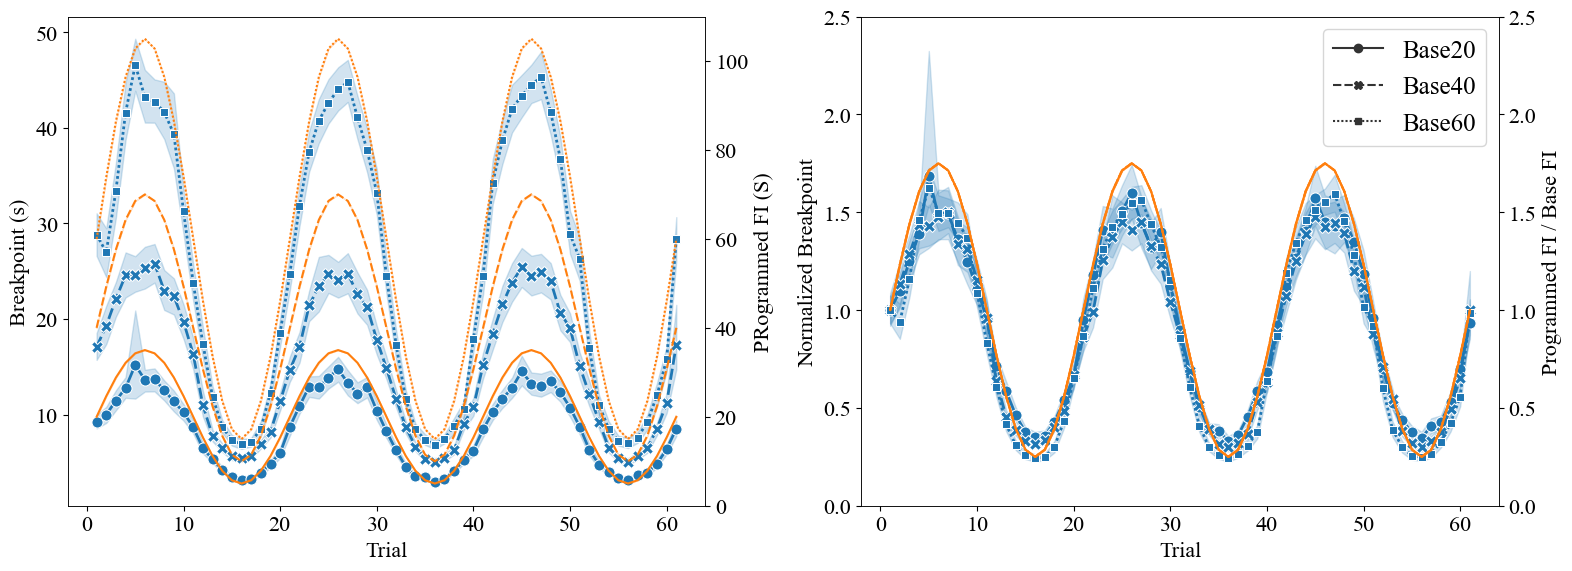

In [194]:
fig1 = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.lineplot(data=experimental_data,x="Trial",y="Breakpoint",style="Group", markers = True, color="tab:blue",markersize=8,linewidth=2,legend=None)
plt.ylabel("Breakpoint (s)")
plt.twinx()
sns.lineplot(data=experimental_data,x="Trial",y="ProgFI",style="Group", color="tab:orange",legend=None)
plt.ylabel("PRogrammed FI (S)")
plt.subplot(1,2,2)
sns.lineplot(data=experimental_data,x="Trial",y="NormBP",style="Group", markers = True, color="tab:blue",markersize=8,linewidth=2)
plt.legend(fontsize=18,loc="best")
plt.ylabel("Normalized Breakpoint")
plt.ylim(0,2.5)
plt.twinx()
sns.lineplot(data=experimental_data,x="Trial",y="NormFI",style="Group", color="tab:orange",legend=None)
plt.ylabel("Programmed FI / Base FI")
plt.ylim(0,2.5)
plt.tight_layout()
plt.show()
fig1.savefig("CyclicFig1.png")

In [195]:
#Fit Sinewave eqution to raw data; assess estimates
#Define the  function
def SW(x,B,S,P):
    return B + (S * np.sin((2  * np.pi * (x-1)) / P))

model_collection = pd.DataFrame({'SubjectID' : [], 'Model': [], 'B': [],'Sm': [],'P': [],'AICc':[]})
selected = []
for subj in baseFI_means.SubjectID.unique():
    temp = baseFI_means[baseFI_means['SubjectID']==subj]
    x = temp.Trial.to_numpy()
    y = temp.Breakpoint.to_numpy()
    SWparams = [np.nanmean(y),np.amax(y)-np.nanmean(y),20]
    SWbest_vals = optimization.curve_fit(SW, x, y, SWparams)
    SWres = (2*3)+(61*np.log(np.sum(np.square(SW(x,*SWbest_vals[0])-y)))) + (((2*(np.square(3)))+(2*3))/(61-3-1))
    SWfit = SW(x,*SWbest_vals[0])
    model_collection=model_collection.append({'SubjectID':subj,'Model': 'SineWave','B':SWbest_vals[0][0],'Sm':SWbest_vals[0][1],'P':SWbest_vals[0][2],'AICc':SWres},ignore_index=True)
    baseFI_means.loc[baseFI_means['SubjectID']==subj,'SWfit_raw'] = SWfit
    
raw_model_collect = model_collection

In [196]:
raw_model_collect

,SubjectID,Model,B,Sm,P,AICc
0,21.0,SineWave,9.167060,5.629437,19.963965,279.102697
1,23.0,SineWave,9.792936,6.716153,19.993769,289.174974
2,26.0,SineWave,9.680059,7.247549,20.063507,270.677062
3,28.0,SineWave,8.711062,6.730590,19.934390,354.401954
4,30.0,SineWave,6.679886,3.418922,20.145356,241.679840
5,32.0,SineWave,8.936144,5.585727,20.075345,270.498554
6,33.0,SineWave,8.057175,5.148310,19.905699,289.688153
7,35.0,SineWave,6.852787,4.445026,19.993758,258.500655
8,22.0,SineWave,12.246227,8.386300,19.949323,345.047449
9,24.0,SineWave,16.566061,10.942042,19.927461,367.685786


In [197]:
model_collection = pd.DataFrame({'SubjectID' : [], 'Model': [], 'B': [],'Sm': [],'P': [],'AICc':[]})
selected = []
for subj in baseFI_means.SubjectID.unique():
    temp = baseFI_means[baseFI_means['SubjectID']==subj]
    x = temp.Trial.to_numpy()
    y = temp.NormBP.to_numpy()
    SWparams = [np.nanmean(y),np.amax(y)-np.nanmean(y),20]
    SWbest_vals = optimization.curve_fit(SW, x, y, SWparams)
    SWres = (2*3)+(61*np.log(np.sum(np.square(SW(x,*SWbest_vals[0])-y)))) + (((2*(np.square(3)))+(2*3))/(61-3-1))
    SWfit = SW(x,*SWbest_vals[0])
    model_collection=model_collection.append({'SubjectID':subj,'Model': 'SineWave','B':SWbest_vals[0][0],'Sm':SWbest_vals[0][1],'P':SWbest_vals[0][2],'AICc':SWres},ignore_index=True)
    baseFI_means.loc[baseFI_means['SubjectID']==subj,'SWfit_norm'] = SWfit
    
norm_model_collect = model_collection

In [198]:
norm_model_collect

,SubjectID,Model,B,Sm,P,AICc
0,21.0,SineWave,1.043490,0.640801,19.963965,13.991119
1,23.0,SineWave,0.971280,0.666120,19.993769,7.257222
2,26.0,SineWave,1.013707,0.758972,20.063507,-4.610313
3,28.0,SineWave,0.944203,0.729537,19.934390,83.317036
4,30.0,SineWave,1.019182,0.521641,20.145356,12.307521
5,32.0,SineWave,0.937440,0.585967,20.075345,-4.575702
6,33.0,SineWave,0.823631,0.526278,19.905699,11.455554
7,35.0,SineWave,0.676763,0.438979,19.993758,-23.940315
8,22.0,SineWave,0.831192,0.569206,19.949323,16.853724
9,24.0,SineWave,0.864429,0.570964,19.927461,7.414635


In [199]:
#Here exporting the model fits to .csvs to be analyzed in R
raw_model_collect.to_csv("raw_sinewaveFits.csv")
norm_model_collect.to_csv("norm_sinewaveFits.csv")

In [200]:
#Calculate response rate/bin for each FI
fi_rr = all_rr_base.LogRate.groupby([all_rr_base['SubjectID'],all_rr_base['Group'],all_rr_base['ProgFI'],all_rr_base['Bin']]).mean()
fi_rr = fi_rr.reset_index()
fi_rr['ExpRate'] = np.exp(fi_rr.LogRate) - 0.001
fi_rr['UnBin'] = (fi_rr.Bin+1)*(fi_rr.ProgFI*(1/8))
fi_rr['PropBin'] = fi_rr.Bin/7
for subj in fi_rr.SubjectID.unique():
    for FI in fi_rr.ProgFI[fi_rr['SubjectID']==subj].unique():
        fi_rr.loc[(fi_rr['SubjectID']==subj) & (fi_rr['ProgFI']==FI), 'PropRate'] = fi_rr.ExpRate[(fi_rr['SubjectID']==subj) & (fi_rr['ProgFI']==FI)]/np.max(fi_rr.ExpRate[(fi_rr['SubjectID']==subj) & (fi_rr['ProgFI']==FI)])


Next we asked if the scalar invariance observed in the previous graphs would be observed in the response function where response rates are plotted as a function of time for each FI in the sine wave. 

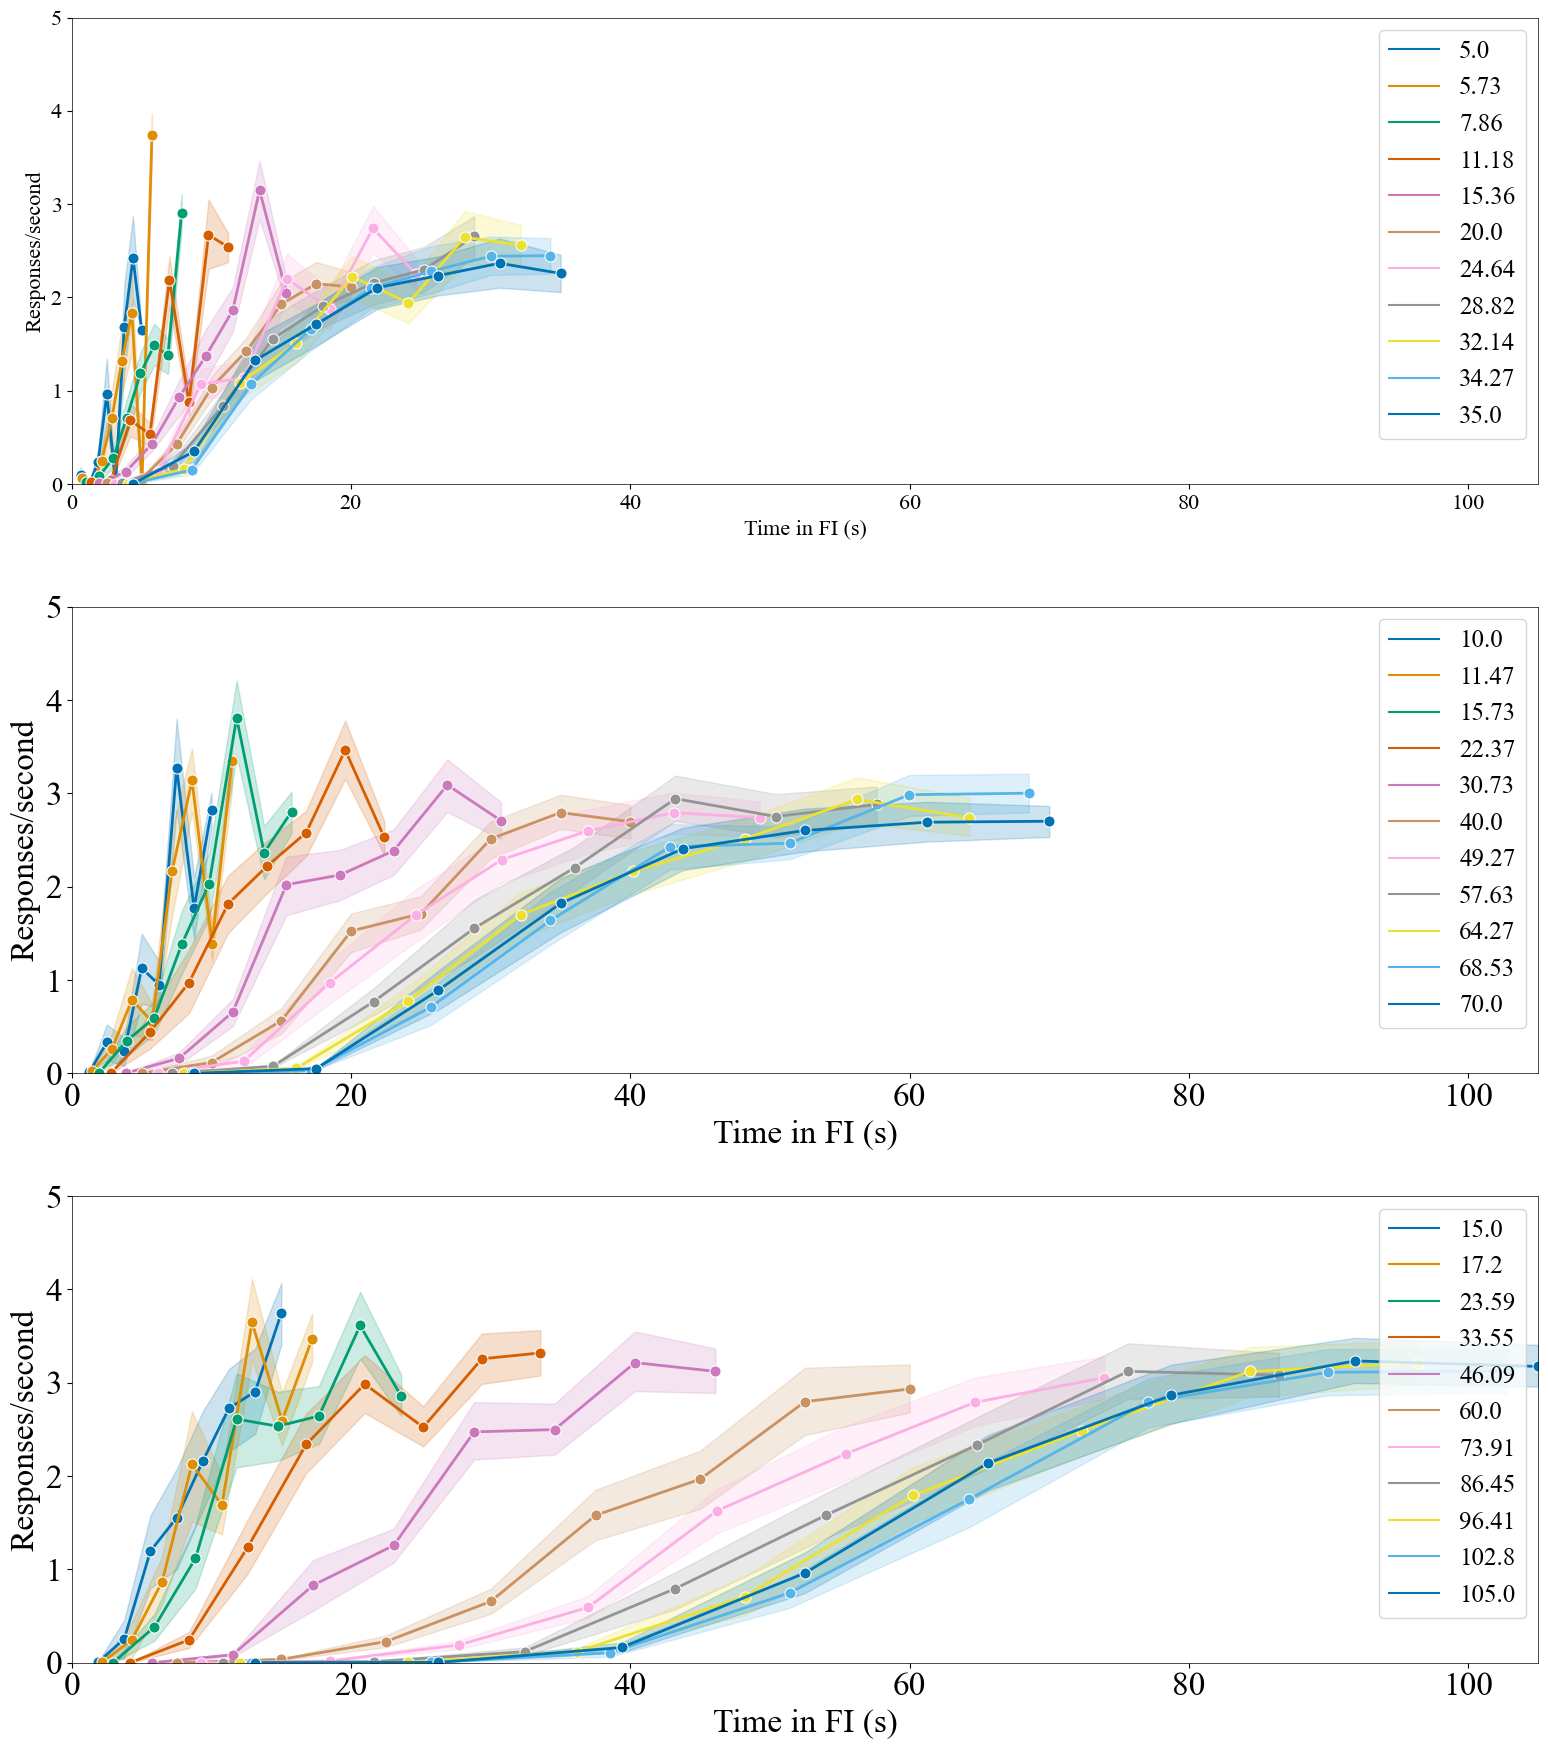

In [201]:
fig2 = plt.figure(figsize=(16,18),tight_layout=True)
for i,group in enumerate(fi_rr.Group.unique(),start=1):
    temp = fi_rr[fi_rr['Group']==group]
    plt.subplot(3,1,i)
    plt.rc('font',size=24)
    sns.lineplot(data=temp,x='UnBin',y='ExpRate',hue='ProgFI',palette="colorblind",markers=True,dashes=False,marker='o',ci=68,markersize=8,linewidth=2)
    plt.ylim([0,5])
    plt.xlim(0,105)
    plt.xlabel('Time in FI (s)')
    plt.ylabel('Responses/second')
    plt.legend(fontsize=18)
plt.show()
fig2.savefig('CyclicFig2.png')

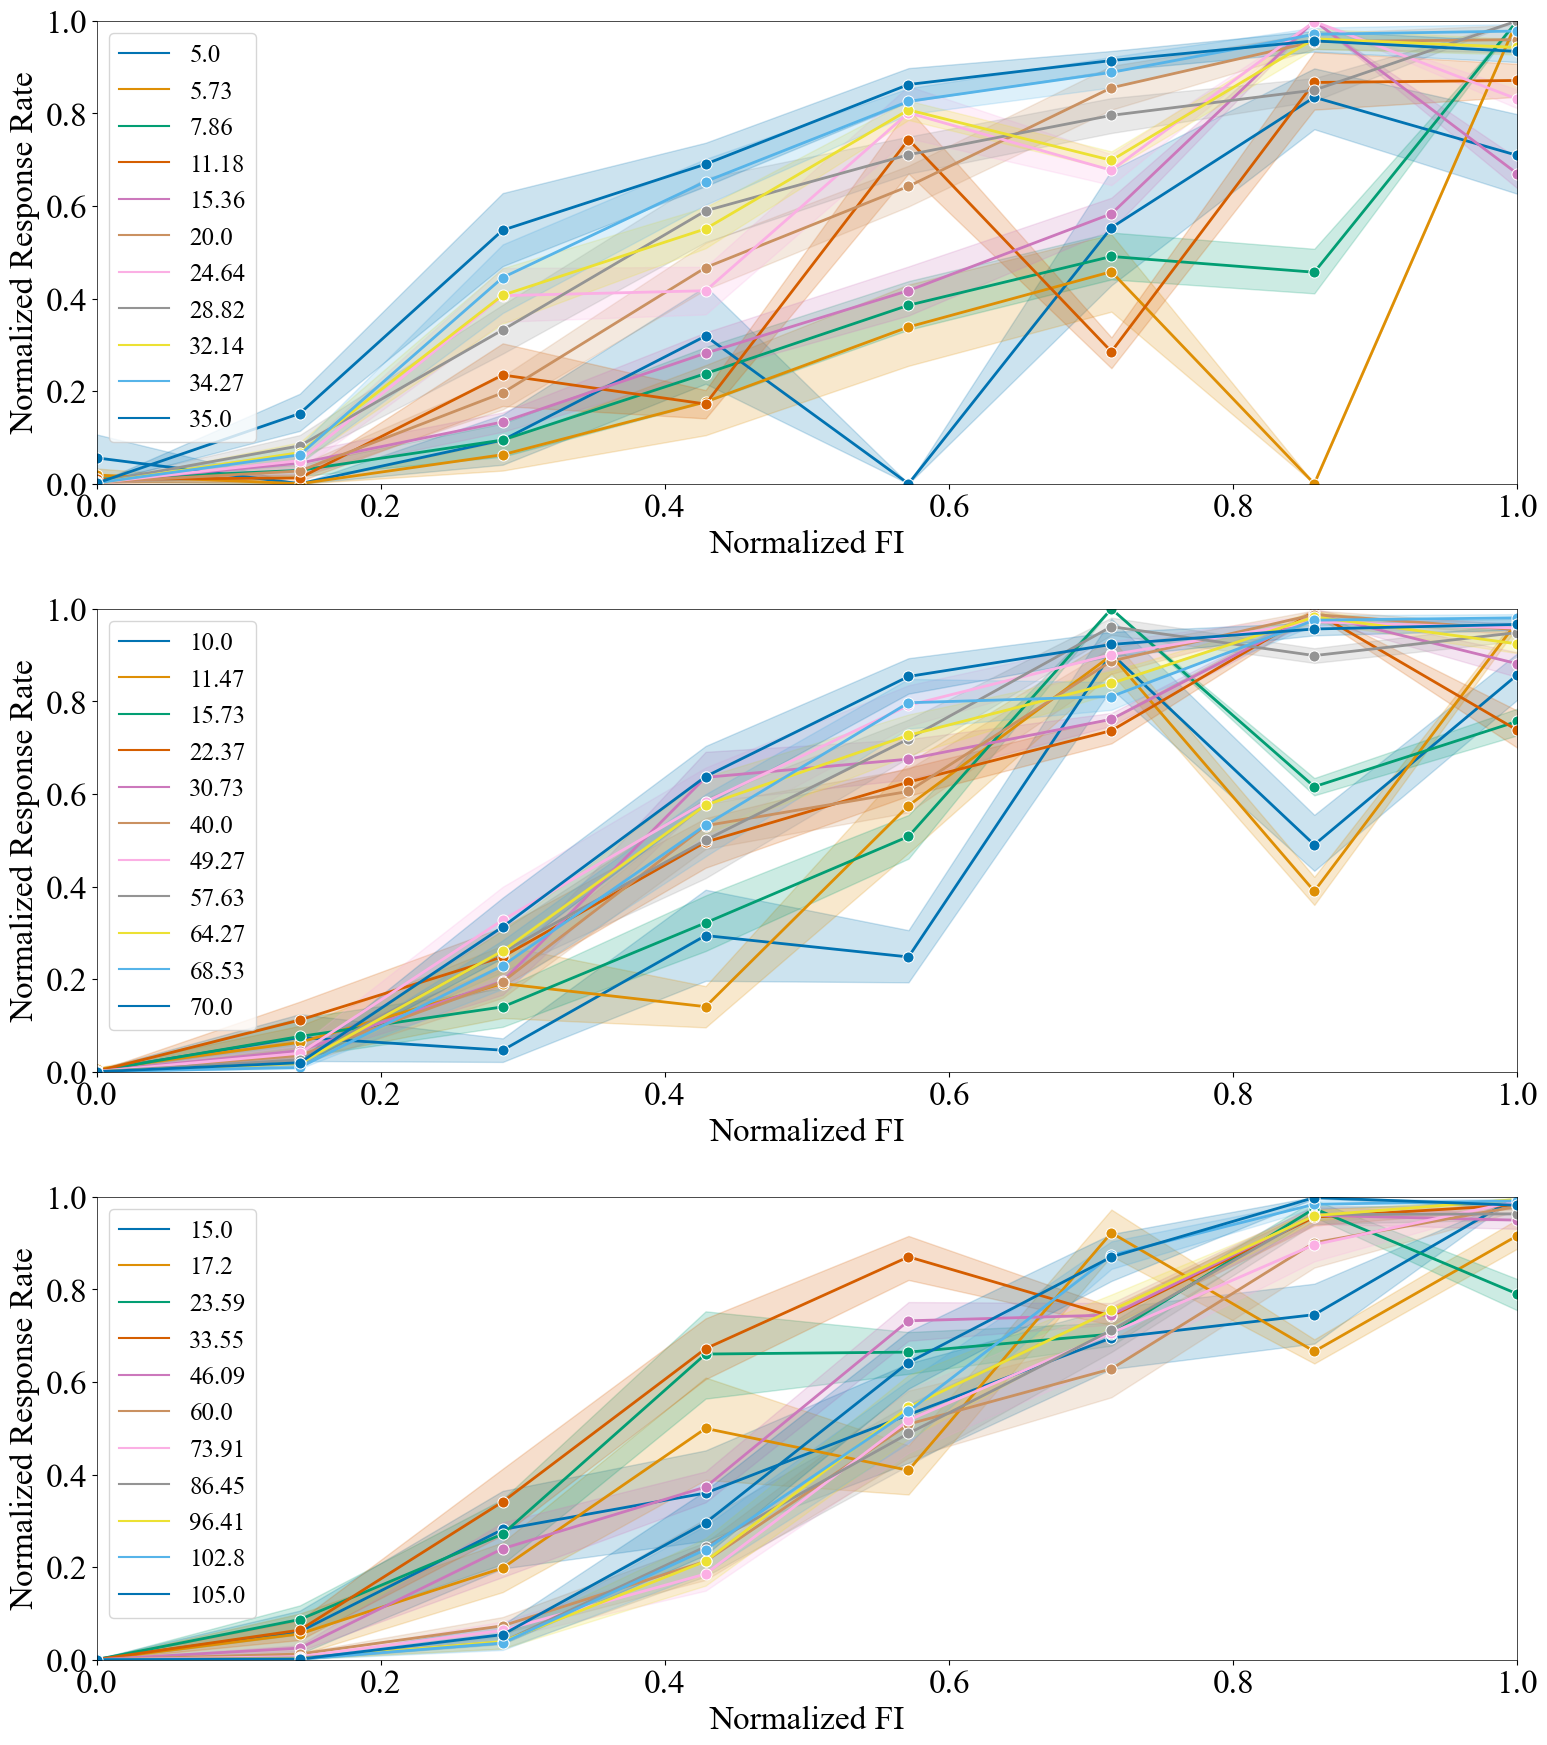

In [202]:
fig3 = plt.figure(figsize=(16,18),tight_layout=True)
for i,group in enumerate(fi_rr.Group.unique(),start=1):
    temp = fi_rr[fi_rr['Group']==group]
    plt.subplot(3,1,i)
    plt.rc('font',size=24)
    sns.lineplot(data=temp,x='PropBin',y='PropRate',hue='ProgFI',palette="colorblind",markers=True,dashes=False,marker='o',ci=68,markersize=8,linewidth=2)
    plt.ylim([0,1])
    plt.xlim(0,1)
    plt.xlabel('Normalized FI')
    plt.ylabel('Normalized Response Rate')
    plt.legend(fontsize=18)
plt.show()
fig3.savefig('CyclicFig3.png')

In [203]:
#fit logistic function
def cumWBL(x,A,L,k):
    return A*(1-np.exp(-pow(x/L,k)))

model_collection = pd.DataFrame({'SubjectID' : [], 'ProgFI': [],'A': [],'L': [],'K': []})

for subj in fi_rr.SubjectID.unique():
    temp = fi_rr[fi_rr['SubjectID']==subj]
    for progFI in temp.ProgFI.unique():
        temp2 = temp[temp['ProgFI']==progFI]
        x = temp2.UnBin.to_numpy()
        y = temp2.ExpRate.to_numpy()
        WBLparams = [max(y)+0.5,np.nanmean(x)+2,5]
        wbl_bounds = (0.01,[max(y)*2, max(x)*2,100])
        WBLbest_vals = optimization.curve_fit(cumWBL, x, y, WBLparams, bounds = wbl_bounds, maxfev=10000)
        SWfit = cumWBL(x,*SWbest_vals[0])
        model_collection=model_collection.append({'SubjectID':subj,'ProgFI':progFI,'A':WBLbest_vals[0][0],'L':WBLbest_vals[0][1],'K':WBLbest_vals[0][2]},ignore_index=True)
        #baseFI_means.loc[baseFI_means['SubjectID']==subj,'SWfit_norm'] = SWfit
        
raw_WBL_fits = model_collection

In [204]:
model_collection = pd.DataFrame({'SubjectID' : [], 'ProgFI': [],'A': [],'L': [],'K': []})

for subj in fi_rr.SubjectID.unique():
    temp = fi_rr[fi_rr['SubjectID']==subj]
    for progFI in temp.ProgFI.unique():
        temp2 = temp[temp['ProgFI']==progFI]
        x = temp2.PropBin.to_numpy()
        y = temp2.PropRate.to_numpy()
        WBLparams = [max(y)+0.5,np.nanmean(x)+0.25,5]
        wbl_bounds = (0.01,[2, max(x)*2,100])        
        WBLbest_vals = optimization.curve_fit(cumWBL, x, y, WBLparams, bounds = wbl_bounds, maxfev=10000)
        SWfit = cumWBL(x,*WBLbest_vals[0])
        model_collection=model_collection.append({'SubjectID':subj,'ProgFI':progFI,'A':WBLbest_vals[0][0],'L':WBLbest_vals[0][1],'K':WBLbest_vals[0][2]},ignore_index=True)
        #baseFI_means.loc[baseFI_means['SubjectID']==subj,'SWfit_norm'] = SWfit
        
norm_WBL_fits = model_collection

In [205]:
raw_WBL_fits.to_csv("rawWBlfits.csv")
norm_WBL_fits.to_csv("normWBlfits.csv")

Here we see clear violations of the scalar property. Rather than quantify these response functions, which are fairly noisy for the relatively short intervals, we decided to look at breakpoints as a function of FI. Thus providing a parallel analysis. 

In [26]:
#cv as a function of interval (for breakpoints)
subject_mean = all_racked_base.groupby([all_racked_base['SubjectID'],all_racked_base['Group'],all_racked_base['ProgFI']]).mean().reset_index()
subject_std = all_racked_base.groupby([all_racked_base['SubjectID'],all_racked_base['Group'],all_racked_base['ProgFI']]).std().reset_index()
subject_cv = pd.DataFrame(np.asfarray(subject_std.Breakpoint/subject_mean.Breakpoint),columns=['Breakpoint'])
subject_cv['SubjectID'] = subject_mean.SubjectID
subject_cv['Group'] = subject_mean.Group
subject_cv['ProgFI'] = subject_mean.ProgFI

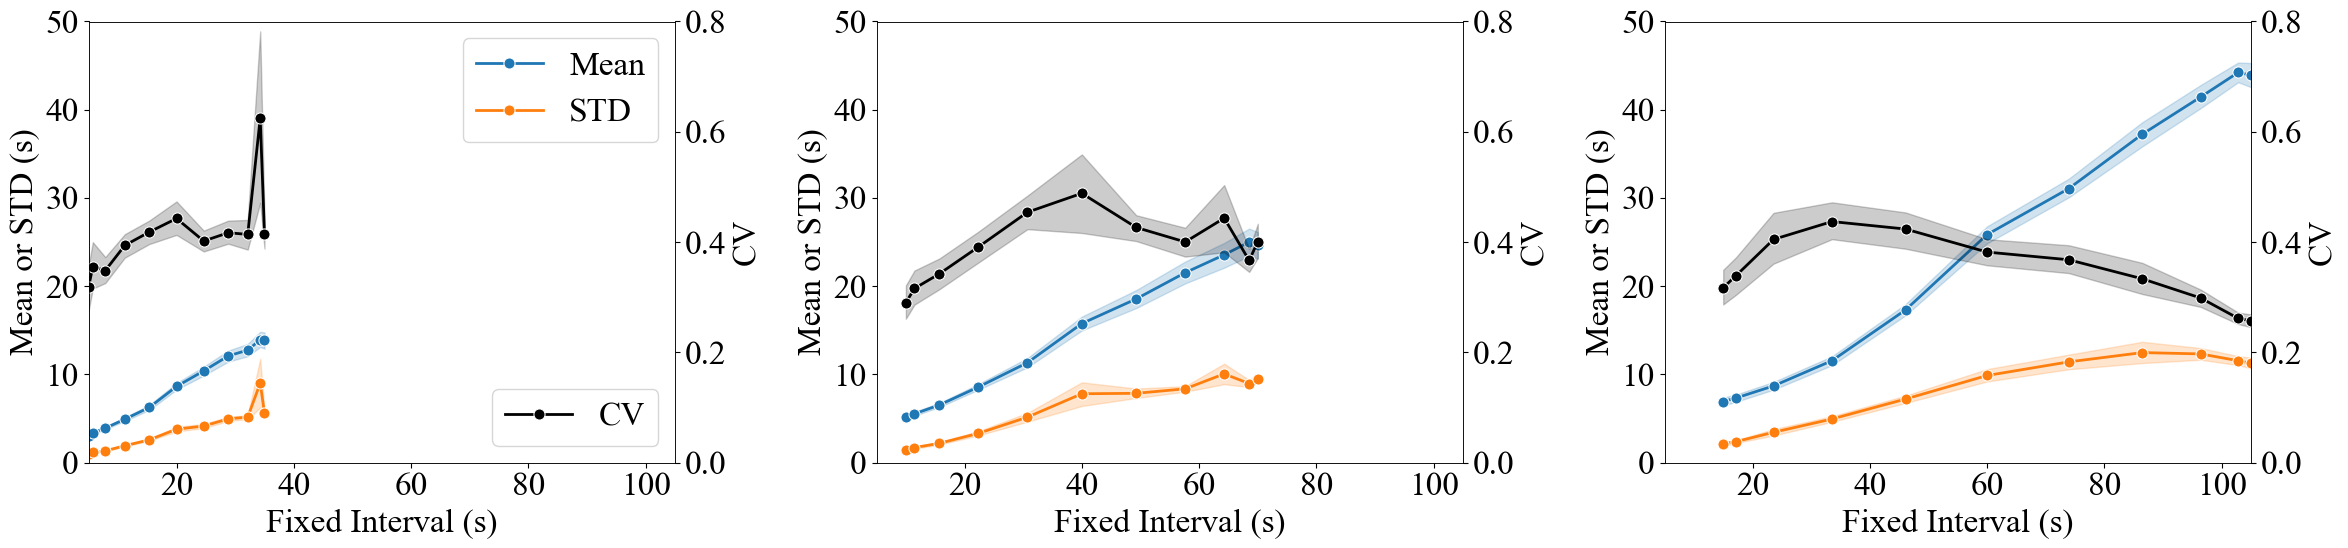

In [27]:
fig4 = plt.figure(figsize=(24,6),tight_layout=True)
for i,group in enumerate(subject_mean.Group.unique(),start=1):
    temp = fi_rr[fi_rr['Group']==group]
    temp_mean = subject_mean[subject_mean['Group']==group]
    temp_std = subject_std[subject_std['Group']==group]
    temp_cv = subject_cv[subject_cv['Group']==group]
    plt.subplot(1,3,i)
    if (i == 2) or (i == 3):
        leg_on = None
    else:
        leg_on = 'brief'
    plt.rc('font',size=24)
    sns.lineplot(data=temp_mean,x='ProgFI',y='Breakpoint',color="tab:blue",markers=True,dashes=False,marker='o',ci=68,markersize=8,linewidth=2,legend=leg_on)
    sns.lineplot(data=temp_std,x='ProgFI',y='Breakpoint',color="tab:orange",markers=True,dashes=False,marker='o',ci=68,markersize=8,linewidth=2,legend=leg_on)
    plt.xlabel('Fixed Interval (s)')
    plt.ylabel('Mean or STD (s)')
    if i == 1:
        plt.legend(['Mean','STD'],loc="upper right")
    plt.ylim([0,50])
    plt.twinx()
    sns.lineplot(data=temp_cv,x='ProgFI',y='Breakpoint',color="black",markers=True,dashes=False,marker='o',ci=68,markersize=8,linewidth=2,legend=leg_on)
    plt.ylim([0,0.8])
    plt.xlim([5,105])
    plt.ylabel('CV')
    if i == 1:
        plt.legend(['CV'],loc="lower right")
plt.show()
fig4.savefig('CyclicFig4.png')

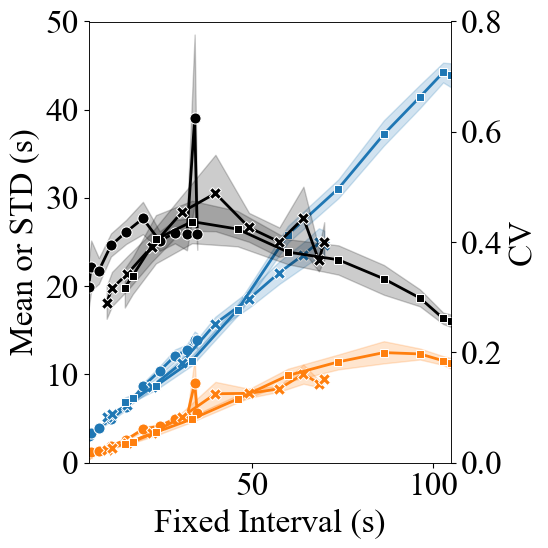

In [28]:
fig5 = plt.figure(figsize=(6,6),tight_layout=True)
plt.rc('font',size=24)
sns.lineplot(data=subject_mean,x='ProgFI',y='Breakpoint',style="Group",color="tab:blue",markers=True,dashes=False,marker='o',ci=68,markersize=8,linewidth=2, legend=None)
sns.lineplot(data=subject_std,x='ProgFI',y='Breakpoint',style="Group",color="tab:orange",markers=True,dashes=False,marker='o',ci=68,markersize=8,linewidth=2, legend=None)
plt.xlabel('Fixed Interval (s)')
plt.ylabel('Mean or STD (s)')
plt.ylim([0,50])
plt.xlim([5,105])
plt.twinx()
sns.lineplot(data=subject_cv,x='ProgFI',y='Breakpoint',style="Group",color="black",markers=True,dashes=False,marker='o',ci=68,markersize=8,linewidth=2, legend=None)
plt.ylim([0,0.8])
plt.ylabel('CV')
plt.show()
fig5.savefig('CyclicFig5.png')

Here we see clearly that the CV is not constant across FIs. Indicating that despite the mean breakpoint appearing scalar invariant, it is in fact not. Normalized variance appears to take on an inverted U-shape. 

***UPDATE WITH TEST***